# 0. Imports and initializations

In [1]:
# for data manipulation
import numpy as np
import pandas as pd

# for data normalization and splitting
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# for models
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import callbacks
from tensorflow.keras import preprocessing
from tensorflow.keras import backend
from tensorflow import random
from tensorflow import shape
from tensorflow import exp
from tensorflow import math
from keras.utils.vis_utils import plot_model
import keras_tuner

# for plots
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# for file management
from os.path import exists
from os import remove

# for sequences
WINDOW_SIZE = 30  # 10 seconds sequences in 5 minutes
WINDOW_SHIFT = 1  # 10 seconds shift

# for models fit
EPOCHS = 100
BATCH_SIZE = 32

plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# 1. Anomaly Detection Task

## 1.1 Utility functions

### 1.1.1 <code>build_heart_rate_model</code>

The funcion will build the best model, given the heart rate time series in input.

In [2]:
def build_heart_rate_model(hp):
    """
    The funcion will build the best model, given the heart rate time series in input.
    """
    
    hp_units_1 = hp.Int('units_1', min_value=3, max_value=64, step=6)
    hp_units_2 = hp.Int('units_2', min_value=3, max_value=64, step=6)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model = models.Sequential()
    model.add(layers.Dense(hp_units_1, activation='relu', input_shape=features[0].shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(hp_units_2, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1))
    model.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate), loss=losses.mse, metrics=[metrics.mae])
    return model

### 1.1.2 <code>get_features</code>

Given the data, the function will produce sequencies of specific window size window shift.

In [3]:
def get_features(data, window_size: int = 30, window_shift: int = 6):
    """
    Given the data, the function will produce sequencies of specific window size window shift.
    """

    features = []

    
    for patient in data.patient.unique():
        rows = data.loc[data.patient == patient].drop(labels=['patient'], axis=1)
        
        for i in range(window_size, len(rows), window_shift):
            features.append(rows[i - window_size:i])
    features = np.array(features)

    return features

## 1.2 Anomaly detection task

Given data from wearable, the goal is to identify anomalous events, i.e. tremors, in a set of observations. Data are collected by patients with and without Parkinson’s Desease. Features include:
- Identification of patient
- Accelerometer readings in the three axes (x, y, z)
- Heart Rate
- Date and timestamp

The training set is composed by control patient, i.e. volunteers without Parkinson’s Desease. Each 1 seconds there is a record and there are missing value on heart rate attribute (labeled with -1). The test set is composed by patient with Parkinson’s Desease, each 10 seconds there is a record.

### 1.2.1 Loading the dataset

In [4]:
data = pd.read_csv('dataset_task_2/train.csv')

data

,patient,x,y,z,heartRate,timestamp,tsDate
0,1502,23,569,878,-1,1568073600000,2019-09-10 00:00:00.003
1,1502,23,571,878,-1,1568073601000,2019-09-10 00:00:01.014
2,1502,23,570,878,-1,1568073602000,2019-09-10 00:00:02.025
3,1502,23,570,878,-1,1568073603000,2019-09-10 00:00:03.035
4,1502,23,570,878,-1,1568073604000,2019-09-10 00:00:04.046
...,...,...,...,...,...,...,...
943517,4506,-636,-399,-654,57,1572479994000,2019-10-30 23:59:54.315
943518,4506,-639,-396,-654,57,1572479995000,2019-10-30 23:59:55.316
943519,4506,-638,-396,-655,57,1572479996000,2019-10-30 23:59:56.336
943520,4506,-637,-396,-655,58,1572479997000,2019-10-30 23:59:57.337


### 1.2.2 Dropping not useful columns

In [5]:
data_after_drop = data.drop(labels=['timestamp', 'tsDate'], axis=1)

data_after_drop.head()

,patient,x,y,z,heartRate
0,1502,23,569,878,-1
1,1502,23,571,878,-1
2,1502,23,570,878,-1
3,1502,23,570,878,-1
4,1502,23,570,878,-1


### 1.2.3 Plotting data

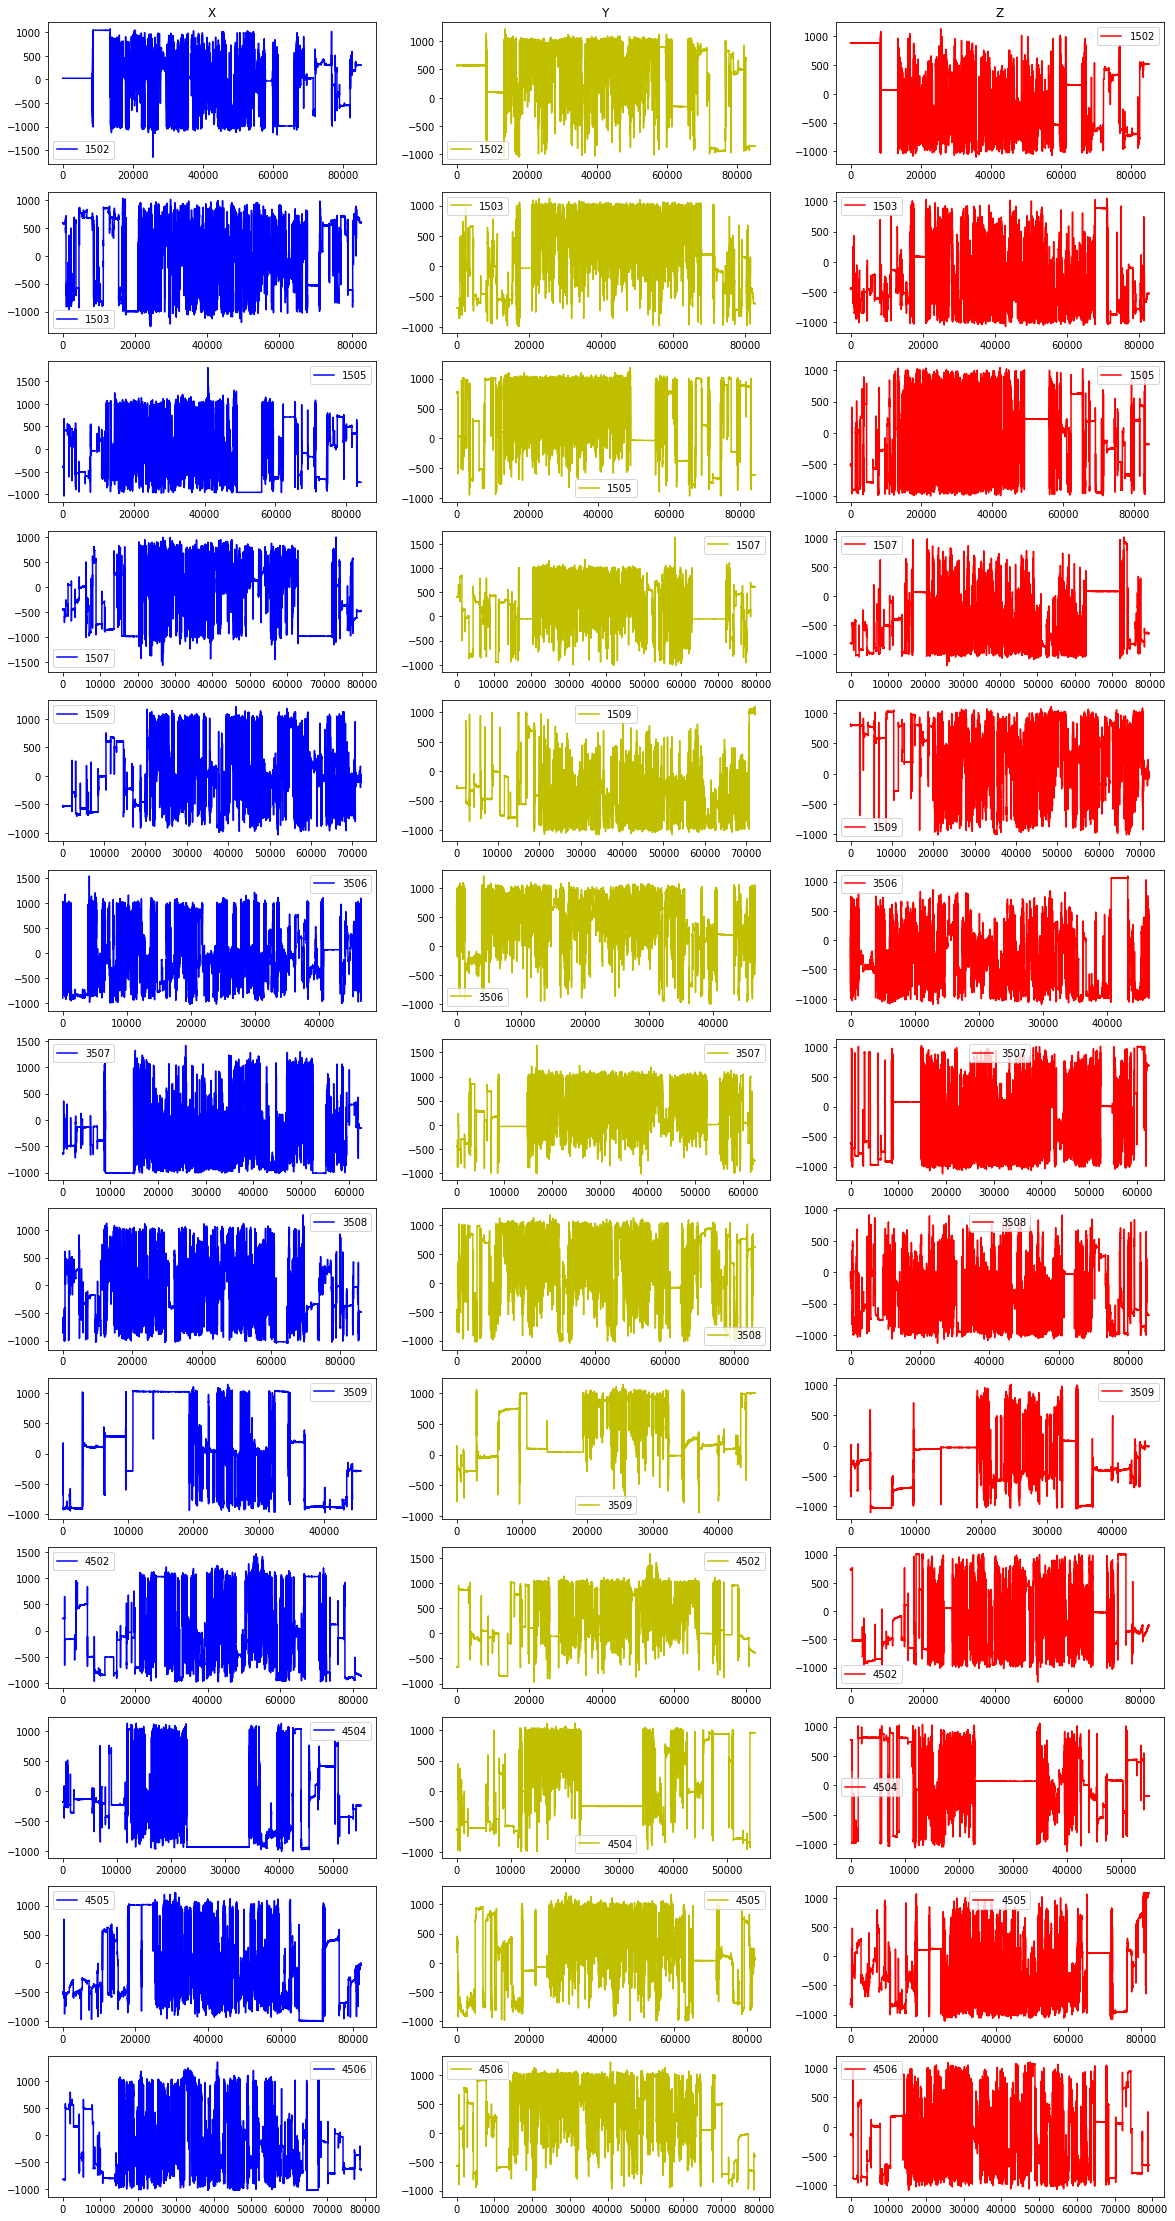

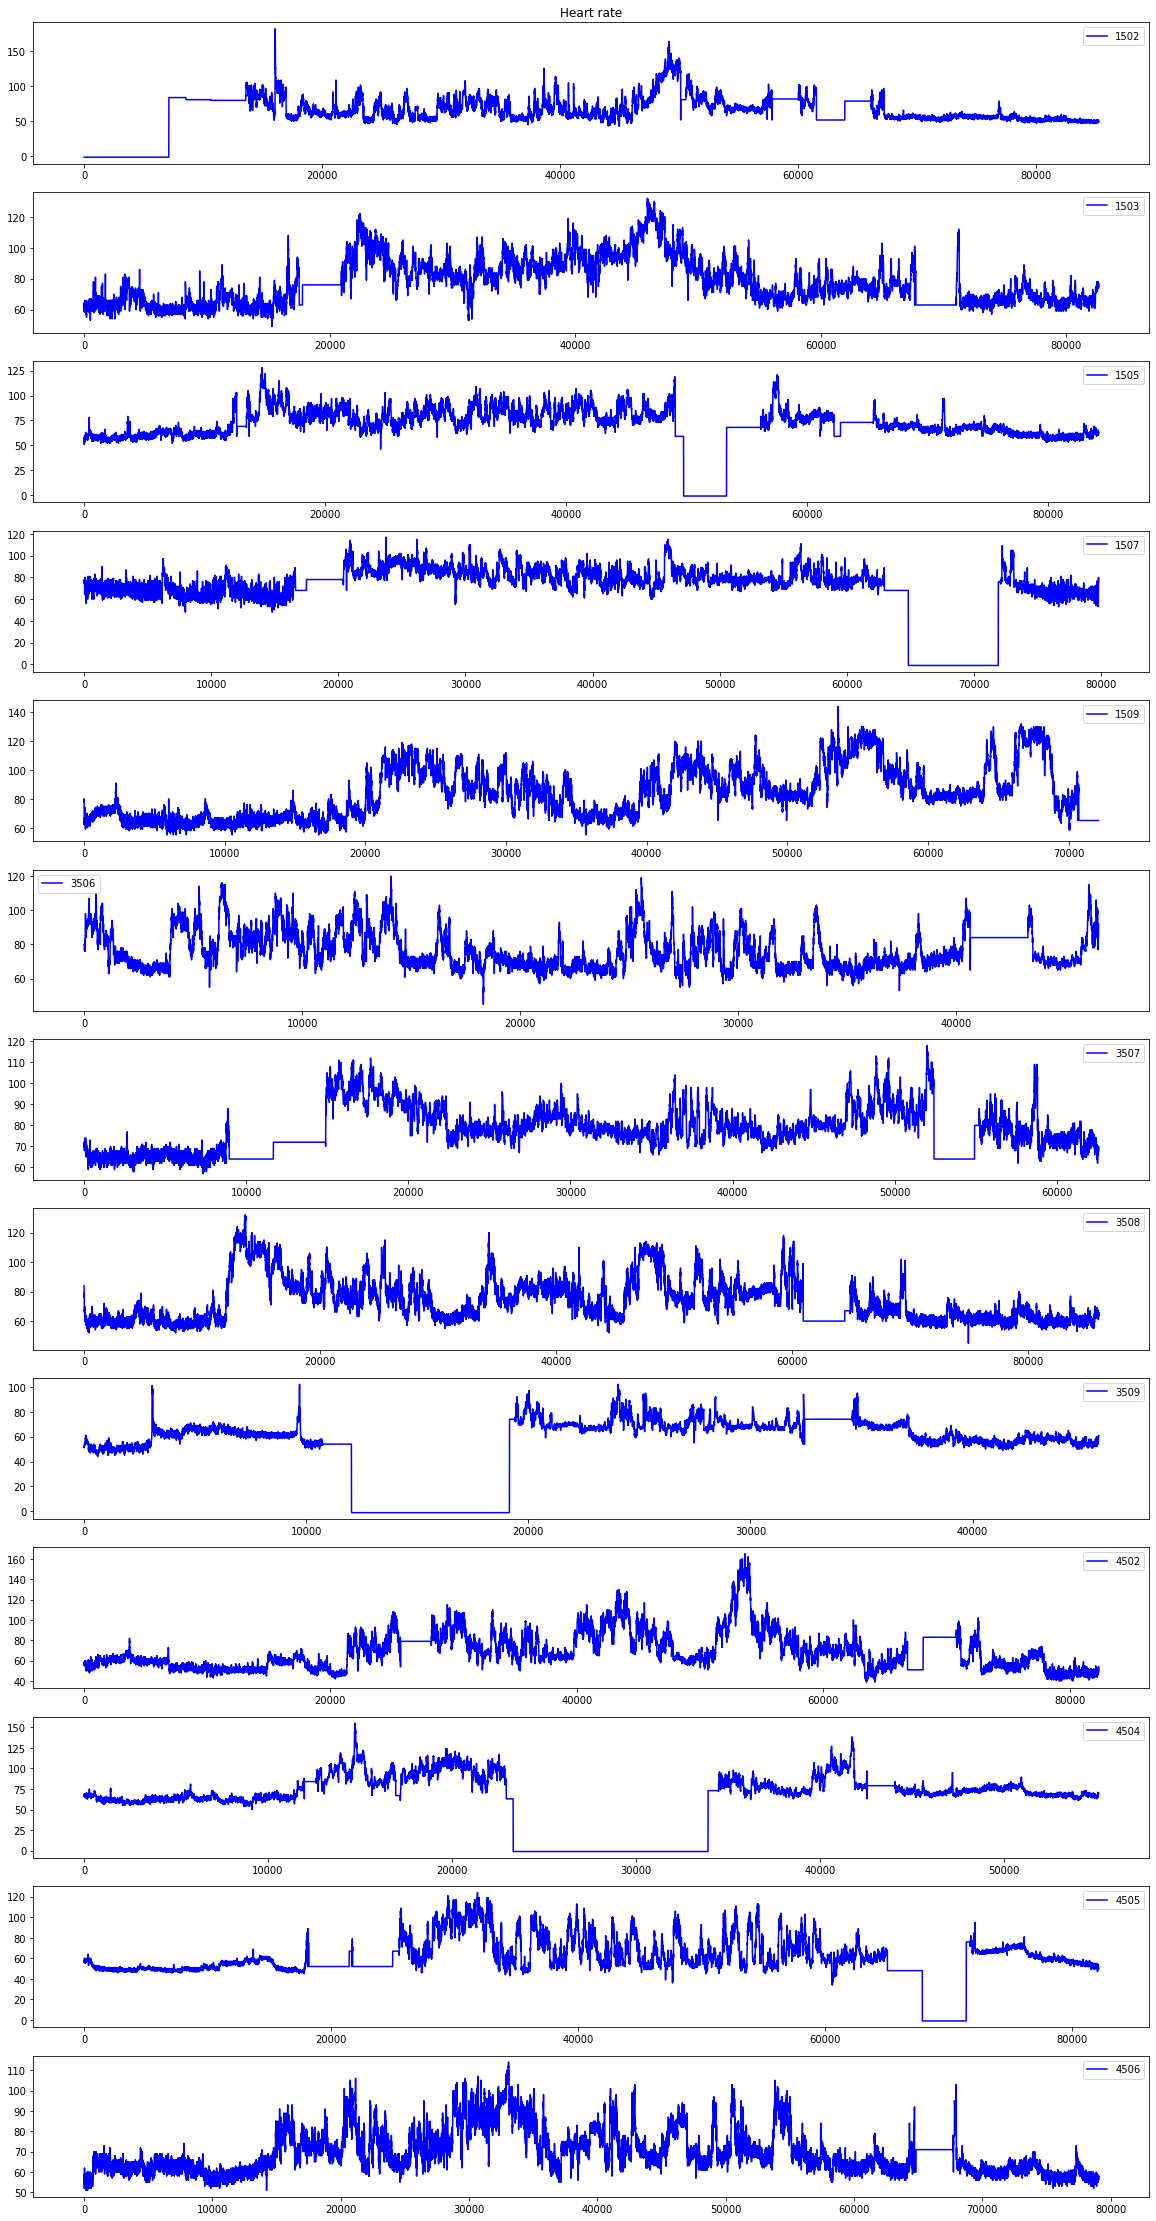

In [6]:
plt.rcParams['figure.figsize'] = (20, 40)
fig, axs = plt.subplots(13, 3)
axs[0, 0].set_title(f'X')
axs[0, 1].set_title(f'Y')
axs[0, 2].set_title(f'Z')
count = 0
for patient in data_after_drop.patient.unique():
    rows = data_after_drop.loc[data_after_drop.patient == patient]
    axs[count, 0].plot(range(len(rows)), rows.x, 'b', label=f'{patient}')
    axs[count, 0].legend()
    axs[count, 1].plot(range(len(rows)), rows.y, 'y', label=f'{patient}')
    axs[count, 1].legend()
    axs[count, 2].plot(range(len(rows)), rows.z, 'r', label=f'{patient}')
    axs[count, 2].legend()
    
    count += 1
plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

plt.rcParams['figure.figsize'] = (20, 40)
fig, axs = plt.subplots(13, 1)
axs[0].set_title(f'Heart rate')
count = 0
for patient in data_after_drop.patient.unique():
    rows = data_after_drop.loc[data_after_drop.patient == patient]
    axs[count].plot(range(len(rows)), rows.heartRate, 'b', label=f'{patient}')
    axs[count].legend()
    count += 1
plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

### 1.2.4 Drop missing values

In [7]:
data_after_clean = data_after_drop.drop(data_after_drop[data_after_drop.heartRate == -1].index)

data_after_clean

,patient,x,y,z,heartRate
7120,1502,23,570,878,84
7121,1502,23,571,878,84
7122,1502,23,571,878,84
7123,1502,23,571,877,84
7124,1502,23,571,878,84
...,...,...,...,...,...
943517,4506,-636,-399,-654,57
943518,4506,-639,-396,-654,57
943519,4506,-638,-396,-655,57
943520,4506,-637,-396,-655,58


### 1.2.5 Plotting cleaned data

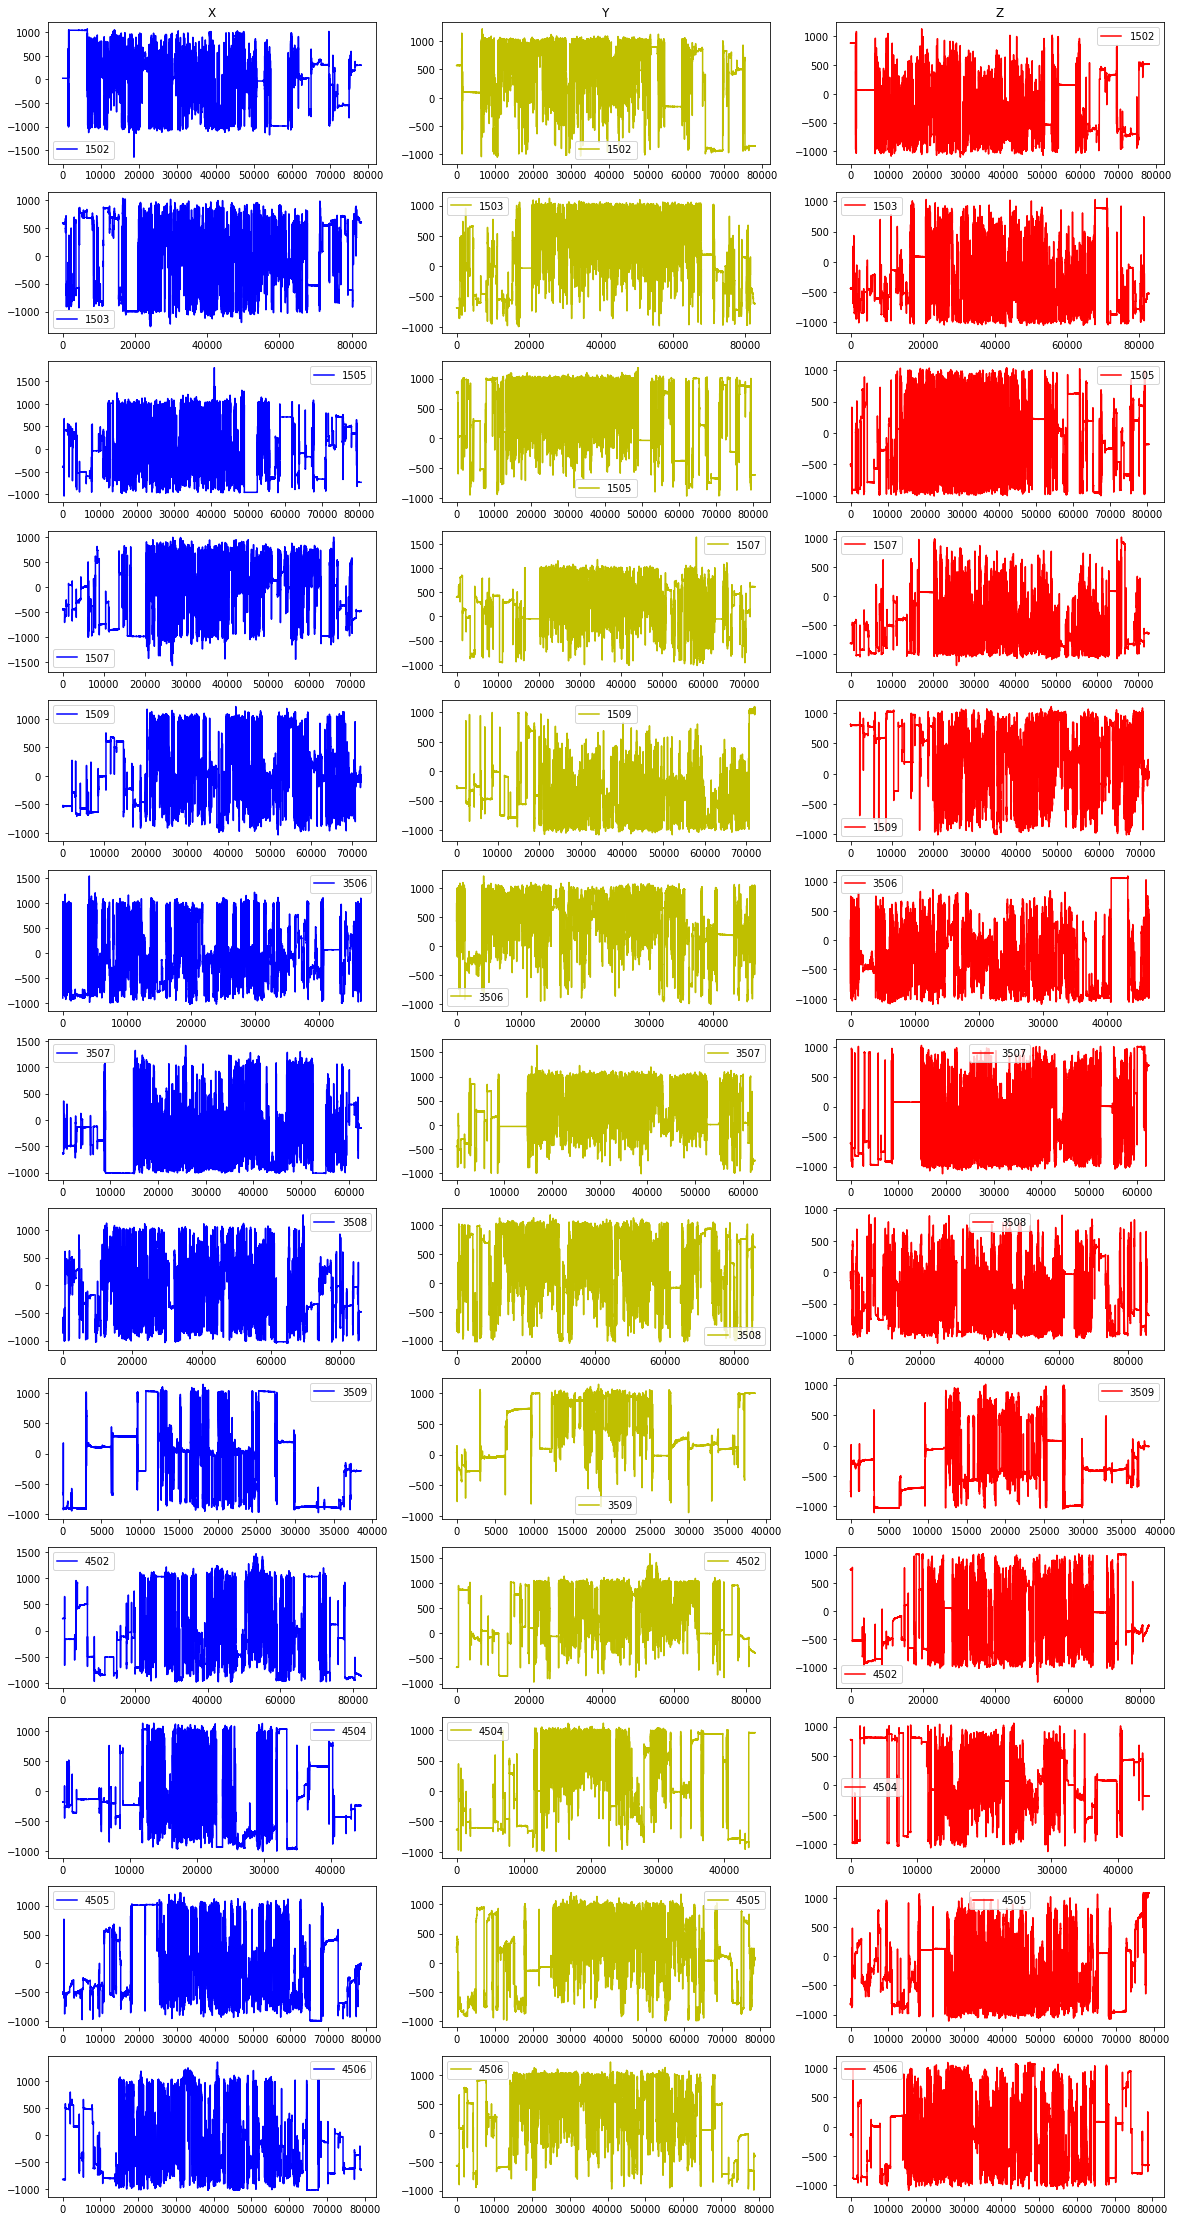

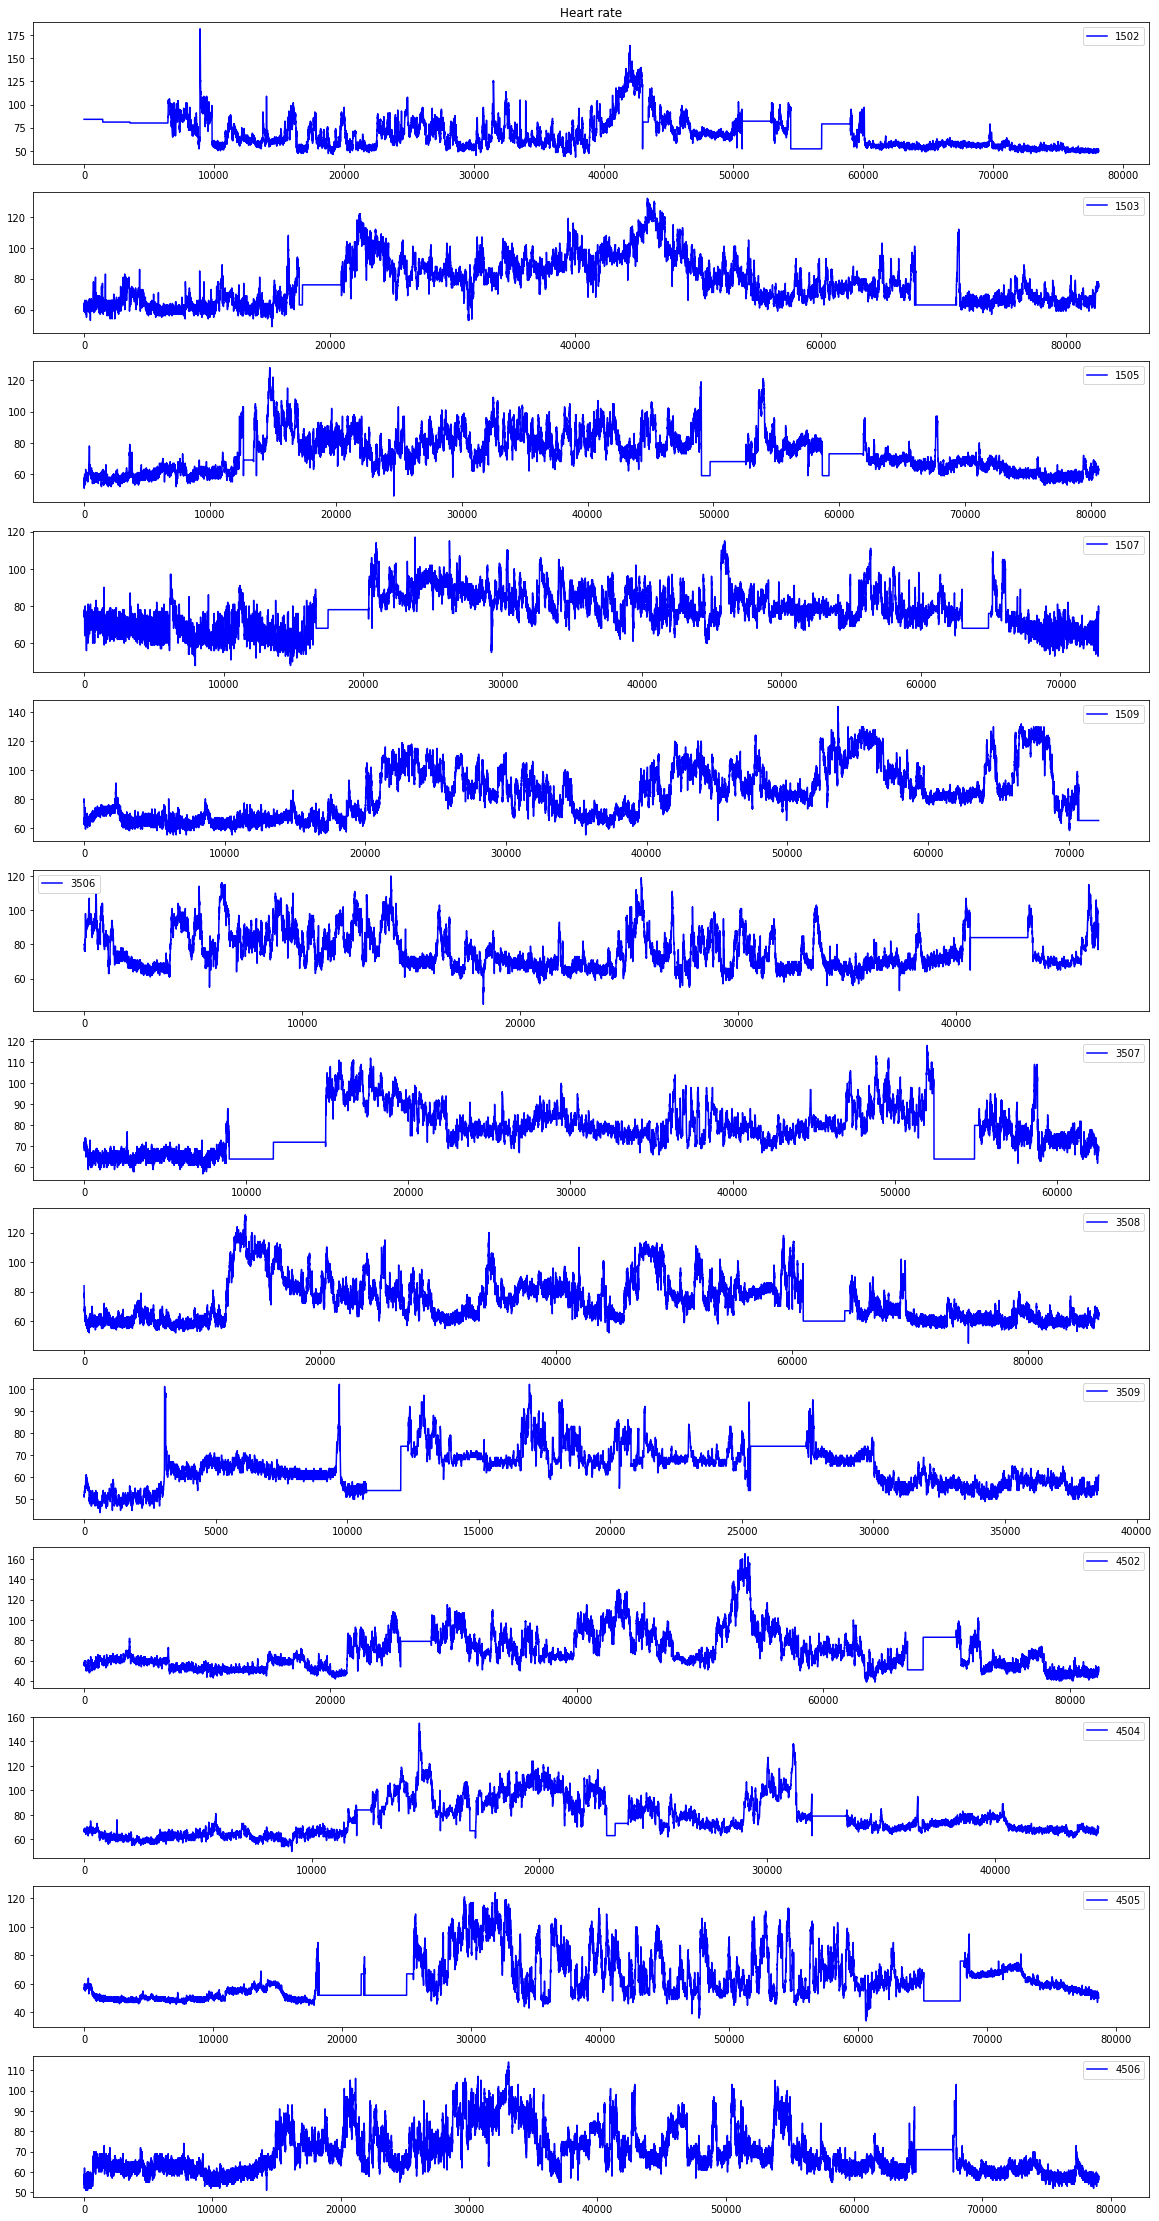

In [8]:
plt.rcParams['figure.figsize'] = (20, 40)
fig, axs = plt.subplots(13, 3)
axs[0, 0].set_title(f'X')
axs[0, 1].set_title(f'Y')
axs[0, 2].set_title(f'Z')
count = 0
for patient in data_after_clean.patient.unique():
    rows = data_after_clean.loc[data_after_clean.patient == patient]
    axs[count, 0].plot(range(len(rows)), rows.x, 'b', label=f'{patient}')
    axs[count, 0].legend()
    axs[count, 1].plot(range(len(rows)), rows.y, 'y', label=f'{patient}')
    axs[count, 1].legend()
    axs[count, 2].plot(range(len(rows)), rows.z, 'r', label=f'{patient}')
    axs[count, 2].legend()
    
    count += 1
plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

plt.rcParams['figure.figsize'] = (20, 40)
fig, axs = plt.subplots(13, 1)
axs[0].set_title(f'Heart rate')
count = 0
for patient in data_after_clean.patient.unique():
    rows = data_after_clean.loc[data_after_clean.patient == patient]
    axs[count].plot(range(len(rows)), rows.heartRate, 'b', label=f'{patient}')
    axs[count].legend()
    count += 1
plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

### 1.2.6 Change granularity

We are going to have ten 1 second sequences in one single 10 seconds sequence.

In [9]:
data_after_shrink = pd.DataFrame(columns=['patient', 'x', 'y', 'z', 'heartRate'])

for patient in data_after_clean.patient.unique():
    rows = data_after_clean.loc[data_after_clean.patient == patient]
    for i in range(10, len(rows), 10):
        elements = rows[i - 10:i]
        temp = pd.DataFrame(
            data=[[patient, elements.x.mean(), elements.y.mean(), elements.z.mean(), elements.heartRate.mean()]],
            columns=['patient', 'x', 'y', 'z', 'heartRate']
        )
        data_after_shrink = data_after_shrink.append(temp, ignore_index=True)
        
data_after_shrink

,patient,x,y,z,heartRate
0,1502,23.0,570.7,877.5,84.0
1,1502,23.2,571.0,877.4,84.0
2,1502,23.0,570.7,877.6,84.0
3,1502,22.9,570.8,877.0,84.0
4,1502,23.0,570.6,877.5,84.0
...,...,...,...,...,...
90436,4506,-635.3,-395.5,-657.0,57.0
90437,4506,-639.7,-395.1,-653.3,56.1
90438,4506,-641.2,-393.7,-653.3,56.0
90439,4506,-640.2,-394.0,-653.6,56.2


### 1.2.7 Data normalization

In [10]:
data_after_normalization = pd.DataFrame(data_after_shrink, columns=['patient', 'x', 'y', 'z', 'heartRate'])

x_scaler = StandardScaler()
x_scaler.fit(np.reshape(data_after_normalization.x.to_numpy(), (-1, 1)))
data_after_normalization.x = x_scaler.transform(np.reshape(data_after_normalization.x.to_numpy(), (-1, 1)))

y_scaler = StandardScaler()
y_scaler.fit(np.reshape(data_after_normalization.y.to_numpy(), (-1, 1)))
data_after_normalization.y = y_scaler.transform(np.reshape(data_after_normalization.y.to_numpy(), (-1, 1)))

z_scaler = StandardScaler()
z_scaler.fit(np.reshape(data_after_normalization.z.to_numpy(), (-1, 1)))
data_after_normalization.z = z_scaler.transform(np.reshape(data_after_normalization.z.to_numpy(), (-1, 1)))

heart_rate_scaler = StandardScaler()
heart_rate_scaler.fit(np.reshape(data_after_normalization.heartRate.to_numpy(), (-1, 1)))
data_after_normalization.heartRate = heart_rate_scaler.transform(np.reshape(data_after_normalization.heartRate.to_numpy(), (-1, 1)))

data_after_normalization

,patient,x,y,z,heartRate
0,1502,0.168966,0.555801,2.141182,0.708872
1,1502,0.169335,0.556365,2.140987,0.708872
2,1502,0.168966,0.555801,2.141377,0.708872
3,1502,0.168781,0.555989,2.140208,0.708872
4,1502,0.168966,0.555613,2.141182,0.708872
...,...,...,...,...,...
90436,4506,-1.046407,-1.261544,-0.847293,-1.075958
90437,4506,-1.054530,-1.260792,-0.840087,-1.135452
90438,4506,-1.057299,-1.258159,-0.840087,-1.142063
90439,4506,-1.055453,-1.258723,-0.840671,-1.128842


### 1.2.8 Sequences generation

We segment the dataset in sequences of fixed window size/shift

In [11]:
features = get_features(data_after_normalization, window_size=WINDOW_SIZE, window_shift=WINDOW_SHIFT)

len(features)

90051

### 1.2.9 VAE modeling

In [12]:
timesteps = features.shape[1]  # Length of your sequences
input_dim = features.shape[2]

inputs = layers.Input(shape=(timesteps, input_dim))
encoded = layers.LSTM(units=256, return_sequences=True)(inputs)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.LSTM(units=256)(encoded)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(units=512, activation='relu')(encoded)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(units=256, activation='relu')(encoded)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(units=128, activation='relu')(encoded)

z_mean = layers.Dense(units=128)(encoded)
z_logvar = layers.Dense(units=128)(encoded)

def sampling(args):
    z_mean, z_logvar = args
    eps = random.normal(shape=shape(z_mean))
    return eps * exp(z_logvar * .5) + z_mean

z = layers.Lambda(sampling, output_shape=(128,))([z_mean, z_logvar])

decoded = layers.Dense(units=128, activation='relu')(z)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(units=256, activation='relu')(decoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(units=512, activation='relu')(decoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.RepeatVector(timesteps)(decoded)
decoded = layers.LSTM(units=256, return_sequences=True)(decoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.LSTM(units=256, return_sequences=True)(decoded)
decoded = layers.Dense(units=input_dim)(decoded)

vae = models.Model(inputs, decoded)
vae.summary()
plot_model(vae, to_file='task_2/models/vae.png', show_shapes=True, show_layer_names=True)

reconstruction_loss = losses.mse(inputs, decoded)
kl_loss = 1 + z_logvar - backend.square(z_mean) - backend.exp(z_logvar * .5)
kl_loss = backend.mean(kl_loss)
kl_loss *= -0.5
vae_loss = backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['mean_absolute_error'])

2022-01-18 14:06:56.716407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-18 14:06:56.845508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-18 14:06:56.846624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-18 14:06:56.848102: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 4)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 30, 256)      267264      ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 30, 256)      0           ['lstm[0][0]']                   
                                                                                                  
 lstm_1 (LSTM)                  (None, 256)          525312      ['dropout[0][0]']                
                                                                                              

In [13]:
train_features, val_features, train_labels, val_labels = train_test_split(features, features, test_size=0.2, random_state=7)

In [14]:
if not exists('task_2/models/vae.index'):
    model_checkpoint_callback = callbacks.ModelCheckpoint('task_2/models/vae', save_weights_only=True, monitor='val_mean_absolute_error', mode='min', save_best_only=True)
    history = vae.fit(train_features, train_labels, validation_data=(val_features, val_labels), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[model_checkpoint_callback])

vae.load_weights('task_2/models/vae')

### 1.2.9 Plotting loss and MAE

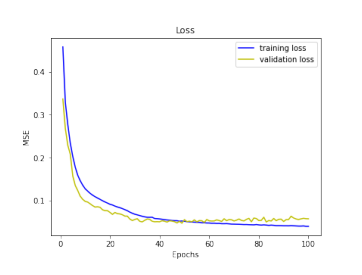

In [15]:
if not exists('task_2/plots/loss.png'):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, EPOCHS + 1)
    plt.plot(epochs, loss, 'b', label='training loss')
    plt.plot(epochs, val_loss, 'y', label='validation loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.savefig('task_2/plots/loss.png')
    plt.show()
else:
    img = mpimg.imread('task_2/plots/loss.png')
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

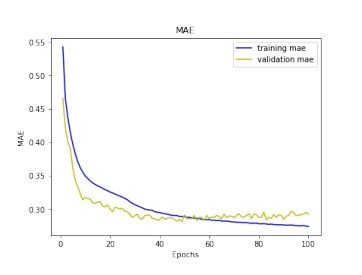

In [16]:
if not exists('task_2/plots/mae.png'):
    mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']
    epochs = range(1, EPOCHS + 1)
    plt.plot(epochs, mae, 'b', label='training mae')
    plt.plot(epochs, val_mae, 'y', label='validation mae')
    plt.title('MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.savefig('task_2/plots/mae.png')
    plt.show()
else:
    img = mpimg.imread('task_2/plots/mae.png')
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

### 1.2.10 Predict some sequences

In [17]:
index = 2

test = features[index].reshape((1, features[index].shape[0], features[index].shape[1]))
prediction = vae.predict(test)

print(f'expected - actual')
for i in range(len(test[0])):
    print(f'{test[0][i]} - {prediction[0][i]}')

2022-01-18 14:07:10.784050: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


expected - actual
[0.16896583 0.55580091 2.14137667 0.7088722 ] - [0.21546859 0.4650029  1.956849   0.5540886 ]
[0.16878121 0.555989   2.14020816 0.7088722 ] - [0.24749519 0.52291733 2.0723197  0.6743661 ]
[0.16896583 0.55561282 2.14118192 0.7088722 ] - [0.28236425 0.5689783  2.0750558  0.70605594]
[0.1695197  0.555989   2.14157142 0.7088722 ] - [0.2777783  0.58077973 2.0847688  0.72033775]
[0.16933508 0.55655328 2.14118192 0.7088722 ] - [0.27138224 0.59317875 2.0939837  0.7219608 ]
[0.16915045 0.55486045 2.14098717 0.7088722 ] - [0.266022   0.60661757 2.1004946  0.71884036]
[0.16933508 0.555989   2.14118192 0.7088722 ] - [0.2613897  0.61931056 2.1047995  0.71498805]
[0.16859658 0.55636519 2.14118192 0.7088722 ] - [0.25735918 0.63023514 2.1068492  0.7113791 ]
[0.16896583 0.55580091 2.14118192 0.7088722 ] - [0.25381324 0.63888836 2.1072638  0.70831996]
[0.16933508 0.55542473 2.14059766 0.7088722 ] - [0.25071317 0.6452092  2.1066952  0.7058706 ]
[0.16970432 0.55617709 2.14137667 0.708872

### 1.2.11 Threshold computation

In [18]:
loss, mae = vae.evaluate(features, features)

2815/2815 [==============================] - 118s 41ms/step - loss: 0.0457 - mean_absolute_error: 0.2807


In [19]:
features_pred = vae.predict(features, verbose=1)

2815/2815 [==============================] - 111s 40ms/step


In [20]:
features_mae = np.mean(np.mean(np.abs(features_pred - features), axis=2), axis=1)
threshold = np.mean(features_mae) + np.std(features_mae)

print(f'Threshold: {threshold}')

Threshold: 0.43064704631987627


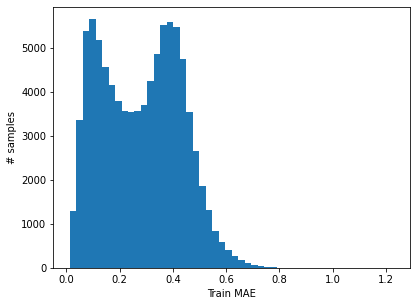

In [21]:
plt.hist(features_mae, bins=50)
plt.xlabel('Train MAE')
plt.ylabel('# samples')
plt.show()

### 1.2.12 Test set loading and preparation

In [22]:
original_test_data = pd.read_csv('dataset_task_2/test.csv')
test_data = original_test_data.drop(labels=['timestamp', 'tsDate'], axis=1)

test_data.x = x_scaler.transform(np.reshape(test_data.x.to_numpy(), (-1, 1)))
test_data.y = y_scaler.transform(np.reshape(test_data.y.to_numpy(), (-1, 1)))
test_data.z = z_scaler.transform(np.reshape(test_data.z.to_numpy(), (-1, 1)))
test_data.heartRate = heart_rate_scaler.transform(np.reshape(test_data.heartRate.to_numpy(), (-1, 1)))

patients = []
for patient in test_data.patient.unique():
    patients.append(get_features(test_data[test_data.patient == patient], window_size=WINDOW_SIZE, window_shift=WINDOW_SHIFT))
    
test_data

,patient,x,y,z,heartRate
0,1004,0.082193,0.891169,-0.786919,0.246138
1,1004,-0.253821,1.231616,0.309536,0.246138
2,1004,-0.130123,0.917502,-0.691491,-0.084386
3,1004,-0.802150,0.311846,-0.652540,-0.018281
4,1004,-0.386749,0.808409,-0.338989,0.312243
...,...,...,...,...,...
722782,4002,-0.798458,-0.769684,-1.248482,0.180034
722783,4002,-0.796612,-0.767803,-1.248482,0.312243
722784,4002,-0.796612,-0.767803,-1.248482,0.378348
722785,4002,-0.796612,-0.769684,-1.248482,0.312243


### 1.2.13 Anomaly detection

In [ ]:
test_features_pred = []
for patient in range(len(test_data.patient.unique())):
    test_features_pred.append(vae.predict(patients[patient], verbose=1))

3945/4084 [===========================>..] - ETA: 5s

In [ ]:
test_loss = []
for patient in range(len(test_data.patient.unique())):
    test_loss.append(np.mean(np.mean(np.abs(test_features_pred[patient] - patients[patient]), axis=2), axis=1))

In [ ]:
print(test_data.patient.unique())
#da vedere setenerlo o no

index = 9

print(test_loss[0][index])
actual = pd.DataFrame(patients[0][index], columns=['x', 'y', 'z', 'heartRate'])
prediction = pd.DataFrame(test_features_pred[0][index], columns=['x', 'y', 'z', 'heartRate']) 
plt.plot(actual.x, 'b', label='Actual')
plt.plot(prediction.x, 'r', label='Prediction')
plt.fill_between(np.arange(actual.shape[0]), prediction.x, actual.x, color='lightcoral', label='Error')
plt.ylim(min(test_data.x), max(test_data.x))
plt.legend()
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (20, 5)

patient_index = 0
patient_number = test_data.patient.unique()[patient_index]
print(f'Patient: {patient_number} - heartRate')

anomalies = test_loss[patient_index] > threshold
anomalous_data_indices = []
for data_idx in range(WINDOW_SIZE - 1, len(test_data[test_data.patient == patient_number]) - WINDOW_SIZE + 1):
    if np.all(anomalies[data_idx - WINDOW_SIZE + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

df_subset = test_data.iloc[anomalous_data_indices].heartRate

red_parts = []
first = df_subset.index[0]
previous = first - 1
for index in df_subset.index:
    if previous + 1 == index:
        previous = index
    else:
        red_parts.append(test_data[test_data.patient == patient_number].heartRate[first:previous])
        first = previous = index

fig, ax = plt.subplots()

test_data[test_data.patient == patient_number].heartRate.plot(legend=False, ax=ax)
for red_part in red_parts:
    red_part.plot(legend=False, ax=ax, color='r')

    
plt.savefig('task_2/plots/1004-heartRate.png')

plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

In [ ]:
anomalies_count = []
row_count = []

for i in range(len(test_data.patient.unique())):
    patient_index = i
    patient_number = test_data.patient.unique()[patient_index]

    anomalies = test_loss[patient_index] > threshold
    anomalous_data_indices = []
    for data_idx in range(WINDOW_SIZE - 1, len(test_data[test_data.patient == patient_number]) - WINDOW_SIZE + 1):
        if np.all(anomalies[data_idx - WINDOW_SIZE + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)
            
    anomalies_count.append(len(anomalous_data_indices))
    row_count.append(len(test_data[test_data.patient == patient_number]))

In [ ]:
for i in range(len(test_data.patient.unique())):
    patient_index = i
    patient_number = test_data.patient.unique()[patient_index]
    print(f'Patient {patient_number}:')
    print(f'\t- Observations:\t{row_count[i]}\t-> {(row_count[i] * 10 / 60 / 60):.2f} hours')
    print(f'\t- Anomalies:\t{anomalies_count[i]}\t-> {(anomalies_count[i] * 10 / 60 / 60):.2f} hours')
    print(f'\t% of anomalies:\t{(anomalies_count[i] / row_count[i] * 100):.2f}%')